In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np

dataset_fname = "QSAR_dataset.xlsx"
test_fname = "test_TP1.xlsx"

# Représentation des données
Dans cette étape, nous devons:
- analyser chaque attribut;
- proposer un prétraitement des données;
- sélectionner les 10 meilleurs attributs avec justification statistique;
- visualiser la distribution des 10 meilleurs attributs.

Commençon par charger les données.

### Chargement des données

In [2]:
# Chargement des données d'entraînement
df = pd.read_excel(dataset_fname, index_col=0)
# Lecture rapide des cinq premières entrées pour valider le chargement adéquat des données
df.head(5)

,Class,apol,ASA+,ASA-,a_count,a_donacc,a_heavy,a_hyd,a_IC,a_nC,...,VSA,vsa_acc,vsa_hyd,vsa_pol,vsurf_A,vsurf_R,vsurf_S,vsurf_V,Weight,zagreb
SMILES,,,,,,,,,,,,,,,,,,,,,
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(=O)[O-],Class 2,41.283001,21.282999,622.40619,43,0,43.0,40,49.644451,14,...,421.45898,27.133842,357.37701,27.133842,3.610454,7.831075,-101.933951,-4.007604,713.09796,246
c12c(cccc1)cccc2,Class 2,22.934343,155.975430,156.69504,18,0,10.0,10,17.839369,10,...,151.37508,0.000000,130.88504,0.000000,0.040120,0.087020,-1.132699,-0.044533,128.17400,50
Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)-c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,Class -2,42.919998,38.976181,499.52170,22,0,22.0,22,21.868664,12,...,338.42563,0.000000,345.43402,0.000000,0.048171,0.104483,-1.360008,-0.053470,498.66199,118
ClC1(Cl)C2(Cl)C(Cl)=C(Cl)C1(Cl)C1C2C(Cl)C2(Cl)OC12,Class -2,38.509171,46.270092,421.43369,23,1,19.0,16,38.822643,10,...,293.98846,2.503756,263.09042,2.503756,4.973507,10.787536,-140.417009,-5.520592,423.76498,130
Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)-c1c(Cl)c(Cl)c(Cl)c(Cl)c1,Class -2,41.406792,56.392834,480.49115,22,0,21.0,21,26.558620,12,...,330.35486,0.000000,327.14081,0.000000,0.137724,0.298724,-3.888371,-0.152874,464.21698,112


## Analyser chaque attribut

Dans cette étape, nous analyserons chacun des attributs. Plus spécifiquement, nous devons déterminer les types (catégories, ordinales, cycliques, quantitatifs, etc.) des nos données. Ensuite, nous devons filtrer les valeurs aberrantes ou manquantes. Finalement, nous pouvons procéder à une analyse statistique primaire (moyenne, variance, équart-type, etc.).

#### Attributs quantitatifs et qualitatifs
D'abord, commençons par distinguer les attributs qualitatifs des attributs quantitatifs. Nous portons une attention particulière aux attributs qualitatifs (ou catégoriques) car ceux-ci nécessitent du pré-traitement particulier.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(=O)[O-] to c12c3c4ccc1cccc2ccc3ccc4
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Class          154 non-null    object 
 1   apol           154 non-null    float64
 2   ASA+           152 non-null    float64
 3   ASA-           153 non-null    float64
 4   a_count        154 non-null    int64  
 5   a_donacc       154 non-null    int64  
 6   a_heavy        153 non-null    float64
 7   a_hyd          154 non-null    int64  
 8   a_IC           153 non-null    float64
 9   a_nC           154 non-null    int64  
 10  a_nCl          154 non-null    int64  
 11  a_nF           154 non-null    int64  
 12  a_nH           154 non-null    int64  
 13  balabanJ       154 non-null    float64
 14  bpol           154 non-null    float64
 15  CASA+          154 non-nul

In [4]:
num_cols = df.select_dtypes(exclude=["object", "category"]).columns.tolist()
cat_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()
print("Nombre d'attributs numériques: {}".format(len(num_cols)))
print("Nombre d'attributs catégoriques: {}".format(len(cat_cols)))
if len(cat_cols) > 0:
    print(cat_cols)

Nombre d'attributs numériques: 74
Nombre d'attributs catégoriques: 1
['Class']


Supprimer les entrées dupliquées

In [5]:
n_duplicated_rows = df.duplicated().sum()
df = df.drop_duplicates()
print("Lignes supprimées: {}".format(n_duplicated_rows))
print("Ratio: {:.4f}".format(n_duplicated_rows / len(df)))
assert df.duplicated().sum() == 0, "Erreur: il reste des doublons dans les données"

Lignes supprimées: 22
Ratio: 0.1667


Seul l'attribut `Class` est catégorique, ce qui est normal puisqu'il associe une classe à chacune des observations. Tous nos attributs sont donc numériques, ce qui facilitera grandement notre prétraitement.

#### Valeurs aberrantes
Maintenant, détectons les valeurs abberantes ou invalides (`NaN`, `±inf`, etc.). Dans notre traitement, nous commençons par convertir les valeurs `±inf` en `NaN` afin d'éviter des duplicata de code. En effet, ces valeurs nécessiteront le même pré-traitement alors une stratégie optimale consiste à les considérer de la même façon dès le départ.

In [6]:
df = df.replace([-np.inf, np.inf], np.nan)
nan_cols = df.columns[df.isna().any()]
nan_summary = df[nan_cols].isna().sum().sort_values(ascending=False)
nan_ratio = nan_summary / len(df)
nan_df = pd.concat((nan_summary, nan_ratio), axis=1)
nan_df = nan_df.rename(columns={0: "Count", 1: "Ratio"})
print(nan_df)

         Count     Ratio
vsurf_V     16  0.121212
vsurf_S     12  0.090909
vsurf_R      7  0.053030
ASA+         2  0.015152
ASA-         1  0.007576
a_heavy      1  0.007576
a_IC         1  0.007576


On constate que les variables `vsurf_V` et `vsurf_S` contiennent beaucoup de valeurs manquates (11.69% et 8.44% respectivement). Par contraste, `ASA+`, `ASA-`, `a_heavy` et `a_IC` contiennent seulement entre 1 et 2 observations invalides. Plus tard, nous pourrons probablement les supprimer sans affecter grandement la distribution des données.

#### Valeurs uniques
Finalement, nous devons considérons les valeurs uniques. Celles-ci ne sont pas techniquement invalides, mais peuvent néamoins être ignorées car elles ne contribueront pas à la décision des algorithmes. En effet, puisque ces attributs prennent une seule valeur distincte, elles ne seront pas déterminantes dans la tâche de classification.

In [7]:
uniq_cols = df.columns[df.nunique() == 1]
uniq_cols

Index([], dtype='object')

La liste `uniq_cols` est vide, ce qui implique que tous les attributs possèdent plusieurs valeurs distinctes.

#### Analyse statistique
On peut maintenant extraire certaines statistiques de base pour tous les attributs

In [8]:
df_describe = df.describe()
df_describe

,apol,ASA+,ASA-,a_count,a_donacc,a_heavy,a_hyd,a_IC,a_nC,a_nCl,...,VSA,vsa_acc,vsa_hyd,vsa_pol,vsurf_A,vsurf_R,vsurf_S,vsurf_V,Weight,zagreb
count,132.000000,130.000000,131.000000,132.000000,132.000000,131.000000,132.000000,131.000000,132.000000,132.000000,...,132.000000,132.000000,132.000000,132.000000,132.000000,1.250000e+02,120.000000,116.000000,132.000000,132.000000
mean,34.584853,108.411883,355.786246,23.803030,0.340909,18.633588,17.090909,33.887930,11.590909,3.083333,...,272.305850,7.303351,239.608307,8.481960,2.228107,-8.000000e+08,-62.631951,-2.303986,358.509248,99.893939
std,6.166294,62.988950,114.675033,5.021236,0.923233,5.644883,5.126573,10.360759,2.366930,2.986079,...,55.923287,14.267881,63.545741,14.813392,2.528680,8.944272e+09,70.510090,2.643785,139.187981,33.639594
min,17.148172,8.778115,122.917570,12.000000,0.000000,10.000000,6.000000,12.000000,6.000000,0.000000,...,140.102050,0.000000,67.651054,0.000000,0.011998,-1.000000e+11,-209.769584,-8.247237,128.174000,46.000000
25%,31.307930,69.558443,299.823835,22.000000,0.000000,16.000000,15.000000,29.348074,12.000000,0.000000,...,241.942508,0.000000,203.026003,0.000000,0.123533,2.629501e-01,-128.674633,-4.829376,289.320000,84.000000
50%,35.681965,99.001797,380.565190,22.000000,0.000000,18.000000,17.000000,31.868664,12.000000,4.000000,...,281.908795,0.000000,253.968020,0.000000,0.370593,7.939334e-01,-10.620018,-0.387075,358.650485,94.000000
75%,38.549388,141.947095,427.294460,24.250000,0.000000,19.000000,18.000000,37.512600,12.000000,6.000000,...,301.843680,13.566921,272.261230,13.566921,4.557597,9.767328e+00,-3.386326,-0.128133,411.002485,106.000000
max,52.422001,356.764860,622.904600,43.000000,4.000000,43.000000,40.000000,86.319427,20.000000,10.000000,...,432.120120,59.150364,475.687620,59.150364,7.429943,1.611555e+01,-0.338738,-0.013318,959.170960,246.000000


Cette analyse primaire nous indique que les différentes variables respectent des échelles de grandeur très différentes. Par exemple, `apol` $\in [17, 53]$ tandis que `vsurf_R` $\in [-6.8\mathrm{e+}08, 1.61\mathrm{e-}01]$. Ce constat nous indique qu'un centrage et réduction par équart-type des différentes variables est nécessaire.

Avant de procéder, nous devons gérer les données manquates identifiées précedemment. Commençons par afficher toutes les lignes invalides.

In [9]:
df[df.isna().any(axis=1)]

,Class,apol,ASA+,ASA-,a_count,a_donacc,a_heavy,a_hyd,a_IC,a_nC,...,VSA,vsa_acc,vsa_hyd,vsa_pol,vsurf_A,vsurf_R,vsurf_S,vsurf_V,Weight,zagreb
SMILES,,,,,,,,,,,,,,,,,,,,,
O=C(Oc1c2OC(C)(C)Oc2ccc1)NC,Class 0,32.336308,306.486630,141.64059,29,4,16.0,9,46.721985,11,...,245.45821,18.574432,165.51740,24.257010,2.064277,4.477416e+00,NaN,-2.291347,223.22800,84
S(=O)(=O)([O-])C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,Class -1,28.855000,9.304678,471.28796,29,0,29.0,25,42.639694,8,...,295.50323,48.024784,229.10074,48.024784,6.459191,1.400998e+01,NaN,NaN,499.11697,164
Clc1c(Cl)c(-c2c(Cl)cc(Cl)c(Cl)c2)cc(Cl)c1[O-],Class 0,37.002380,74.775352,427.29446,22,0,19.0,17,34.823284,12,...,292.15103,13.566921,256.45273,13.566921,6.924998,NaN,NaN,NaN,375.87299,100
Brc1c(Br)cc(Oc2c(Br)cc(Br)cc2)c(Br)c1,Class -1,40.505966,84.042198,483.42615,23,0,18.0,17,37.803093,12,...,334.20535,0.000000,325.34479,0.000000,4.503148,9.767328e+00,-127.137380,NaN,564.69098,92
Clc1c(Cl)cc(c(Cl)c1)-c1c(Cl)cc(Cl)cc1,Class -1,35.353966,105.198640,369.40125,22,0,17.0,17,31.868664,12,...,273.52094,0.000000,253.96802,0.000000,0.171580,3.721578e-01,-4.844228,NaN,326.43698,88
ClC(Cl)C(c1c(Cl)cccc1)c1ccc(Cl)cc1,Class -1,40.027931,148.659580,331.21738,28,0,NaN,17,40.083687,14,...,287.76639,0.000000,260.46085,0.000000,0.294936,6.397155e-01,NaN,-0.327379,320.04599,90
Clc1c(Cl)c(Cl)c2c(c1Cl)oc1c(Cl)c(Cl)c(Cl)cc21,Class -1,37.848793,68.882759,420.16150,21,0,20.0,17,29.567631,12,...,294.67117,0.000000,258.93744,0.000000,4.824833,NaN,-136.219507,-5.355565,409.31000,114
S(=O)(=O)([O-])C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,Class -1,23.107000,10.079229,400.27145,23,0,23.0,19,NaN,6,...,240.96204,48.024784,176.99980,48.024784,5.601039,-1.000000e+11,-158.134131,NaN,399.10300,128
Clc1c(Cl)c(c(Cl)c(Cl)c1[O-])-c1c(Cl)cc(Cl)c(Cl)c1,Class 0,38.515587,61.155483,450.25055,22,0,20.0,18,33.436462,12,...,306.83905,13.566921,274.74591,13.566921,6.912943,1.499417e+01,-195.173117,NaN,410.31799,106


On constate que les valeurs invalides pour `ASA-`, `a_heavy` et `a_IC` se trouvent toutes sur des lignes distinctes. Si elles étaient toutes associées à la même ligne, nous aurions pu simplement supprimer cette ligne et perdre moins de 1% des données. Puisque notre jeu de données possèdent seulement $n=154$ observations, les stratégies d'ablation sont rejetées par défaut si elles retirent un trop grand pourcentage des données. Une stratégie alternative consiste à remplacer les valeurs manquantes par une valeur bien représentative. Ainsi, ré-affichons les statistiques élémentaires pour les colonnes invalides seulement.

In [10]:
df[nan_cols].describe()

,ASA+,ASA-,a_heavy,a_IC,vsurf_R,vsurf_S,vsurf_V
count,130.000000,131.000000,131.000000,131.000000,1.250000e+02,120.000000,116.000000
mean,108.411883,355.786246,18.633588,33.887930,-8.000000e+08,-62.631951,-2.303986
std,62.988950,114.675033,5.644883,10.360759,8.944272e+09,70.510090,2.643785
min,8.778115,122.917570,10.000000,12.000000,-1.000000e+11,-209.769584,-8.247237
25%,69.558443,299.823835,16.000000,29.348074,2.629501e-01,-128.674633,-4.829376
50%,99.001797,380.565190,18.000000,31.868664,7.939334e-01,-10.620018,-0.387075
75%,141.947095,427.294460,19.000000,37.512600,9.767328e+00,-3.386326,-0.128133
max,356.764860,622.904600,43.000000,86.319427,1.611555e+01,-0.338738,-0.013318


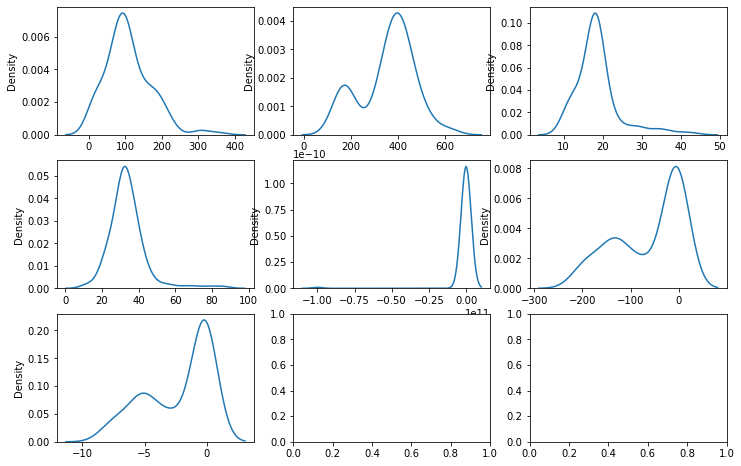

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,8))

# j = 0
# for i in range(len(nan_cols)):
#     col = nan_cols[i]
#     print(i % 3)
#     sns.kdeplot(df[[col]].to_numpy().reshape(-1), ax=axs[i % 3, j])
#     j += 1
#     if j > 2:
#         j = 0
sns.kdeplot(df[["ASA+"]].to_numpy().reshape(-1), ax=axs[0, 0])
sns.kdeplot(df[["ASA-"]].to_numpy().reshape(-1), ax=axs[0, 1])
sns.kdeplot(df[["a_heavy"]].to_numpy().reshape(-1), ax=axs[0, 2])
sns.kdeplot(df[["a_IC"]].to_numpy().reshape(-1), ax=axs[1, 0])
sns.kdeplot(df[["vsurf_R"]].to_numpy().reshape(-1), ax=axs[1, 1])
sns.kdeplot(df[["vsurf_S"]].to_numpy().reshape(-1), ax=axs[1, 2])
sns.kdeplot(df[["vsurf_V"]].to_numpy().reshape(-1), ax=axs[2, 0])

plt.show()

Les diagrammes de densité nous indique que la distribution des variables `a_heavy`, `a_IC` et `vsurf_R` sont plutôt concentrées autour de leur moyenne respective. On peut donc remplacer les valeurs manquantes par la moyenne sans altérer la distribution ou introduire un biais ayant un impact significatif dans la tâche de classification. Pour les autres attributs, c'est-à-dire `ASA+`, `ASA-`, `vsurf_S` et `vsurf_V` , on utilise plutôt la valeur médiane. Mentionner approche intéressante: K-NN ou maximiser le likelihood considérant les autres attributs.

In [12]:
# Remplacement des valeurs manquantes par la moyenne pour les attributs
# `a_heavy`, `a_IC` et `vsurf_R`.
for col in ["a_heavy", "a_IC", "vsurf_R"]:
    df.loc[:, col].fillna(df.loc[:, col].mean(), inplace=True)

# Remplacement des valeurs manquantes par la médiane pour les autres attributs restants
for col in set(nan_cols) - set(["a_heavy", "a_IC", "vsurf_R"]):
    df.loc[:, col].fillna(df.loc[:, col].median(), inplace=True)

# On valide la dernière opération en s'assurant qu'il ne reste aucun attribut avec des 
# valeurs manquates dans les données
n_remaining_nan = df.isna().sum().sum()
assert n_remaining_nan == 0, "Il reste {} valeurs manquantes".format(n_remaining_nan)

Comme mentionné précédemment, les variables respectent des échelles de grandeur très différentes.
Il faut donc les centrer et les réduire.

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

enc = LabelEncoder()
# On copie le dataframe (sans les étiquettes) dans une matrice numpy X
X = df.loc[:, df.columns != "Class"].to_numpy(dtype=np.float32)
y = enc.fit_transform(df.loc[:, "Class"].to_numpy())
# On applique un centrage et une réduction par équart-type de la matrice X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

# On valide la dernière étape en s'assurant que les moyennes et écart-types 
# soient égaux à 0 et 1 respectivement
assert np.allclose(0., X_scaled.mean(axis=0), atol=1e-6), "Moyennes non centrées"
assert np.allclose(1., X_scaled.std(axis=0), atol=1e-6), "Écart-types différents de 1"

[4 4 1 1 1 1 1 3 3 1 3 3 0 3 3 0 3 3 0 3 3 0 0 0 3 0 3 3 3 3 0 0 3 3 0 3 0
 3 3 0 2 2 2 0 0 2 0 0 0 2 2 0 2 0 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 2 0 0 0 0 0
 2 2 2 2 2 2 0 2 2 2 2 0 0 0 0 0 0 0 0 2 2]


### Sélection des 10 meilleurs attributs
Nous présentons trois méthodes différentes pour sélectionner les attributs.
- les dix composantes principales (tirées de l'ACP) des variables non corrélées;
- les dix variables issues de la méthode `SelectKBest` de la librairie `SKLearn`.

In [14]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

clf = SelectKBest(mutual_info_classif, k=10)
clf.fit(df_scaled[num_cols], y)
features_a = list(clf.get_feature_names_out())
features_a

['density',
 'h_logP',
 'logS',
 'mr',
 'PC+',
 'PC-',
 'SlogP',
 'SMR',
 'std_dim1',
 'vdw_area']

In [15]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", random_state=42, max_features=10)
clf.fit(X_scaled, y)
ind = np.argpartition(clf.feature_importances_, -10)[-10:]
features_b = list(df.columns[ind])
features_b

['chi0_C',
 'apol',
 'density',
 'ASA-',
 'chi1',
 'vsa_pol',
 'CASA+',
 'logS',
 'PEOE_VSA_NEG',
 'balabanJ']

In [16]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(verbose=False)
clf.fit(X_scaled, y)
ind = np.argpartition(clf.feature_importances_, -10)[-10:]
features_c = list(df.columns[ind])
features_c

['h_logP',
 'balabanJ',
 'dipole',
 'RPC-',
 'vsa_pol',
 'chi1_C',
 'vsurf_R',
 'npr2',
 'bpol',
 'rgyr']

In [17]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_scaled, y)
ind = np.argpartition(clf.feature_importances_, -10)[-10:]
features_d = list(df.columns[ind])
features_d

[20:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\verdi\anaconda3\envs\anomaly_detection\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


['logP(o/w)',
 'chi1',
 'a_count',
 'vdw_vol',
 'vsa_pol',
 'a_donacc',
 'rsynth',
 'a_nC',
 'pmi',
 'PC+']

In [18]:
from collections import defaultdict, OrderedDict, Counter

def default_value():
    return 0

all_features = features_a + features_b + features_c + features_d
features_dict = Counter(all_features)

features_df = pd.DataFrame(
    list(zip(features_dict.keys(), features_dict.values())),
    columns=["Attribut", "Décompte"]
).sort_values(ascending=False, by="Décompte")
features_df

,Attribut,Décompte
14,vsa_pol,3
0,density,2
2,logS,2
17,balabanJ,2
4,PC+,2
1,h_logP,2
13,chi1,2
23,bpol,1
21,vsurf_R,1
22,npr2,1


In [19]:
selected_features = features_df.loc[:, "Attribut"][0:10].tolist()
X = df_scaled.loc[:, selected_features].to_numpy(dtype=np.float32)
selected_features

['vsa_pol',
 'density',
 'logS',
 'balabanJ',
 'PC+',
 'h_logP',
 'chi1',
 'bpol',
 'vsurf_R',
 'npr2']

Nous procédons maintenant à une réduction de dimension par ACP. Au-lieu d'utiliser la librairie SKLearn, ...

In [20]:
# Création de la matrice de corélation
Sigma = (1 / (len(df))) * (X.T @ X)
# Vérification que la diagonale de la matrice de corélation est contient des uns.
assert np.allclose(np.diag(Sigma), np.ones(Sigma.shape[0]), atol=1e-6)

# Décomposition valeurs, vecteurs propres
eig_vals, eig_vecs = np.linalg.eig(Sigma)
# Trier les vecteurs et valeurs propres de manière décroissante
# https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
idx = eig_vals.argsort()[::-1]   
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

# D'abord on calcule la somme de chaque valeur propre
sum_eigval = np.sum(eig_vals)
# Ensuite, on divise chacune des valeur propre par cette somme
var_prop = eig_vals / sum_eigval
cum_prop = np.cumsum(var_prop)
# Validation que la somme des proportions donne bien 1
assert(np.allclose(var_prop.sum(), 1))

# On crée une table pour présenter les résultats
d = {"Valeur propre": eig_vals, "Pourcentages": np.around(var_prop * 100, 4), "Pourcentages cumulés": np.around(cum_prop * 100, 4)}
eig_df = pd.DataFrame(data=d)
eig_df.head(10)

,Valeur propre,Pourcentages,Pourcentages cumulés
0,4.950010,49.500099,49.500099
1,2.721529,27.215300,76.715401
2,0.986493,9.864900,86.580299
3,0.528668,5.286700,91.866997
4,0.423904,4.239000,96.106003
5,0.172005,1.720100,97.826103
6,0.147249,1.472500,99.298599
7,0.041530,0.415300,99.713898
8,0.021442,0.214400,99.928299
9,0.007169,0.071700,100.000000


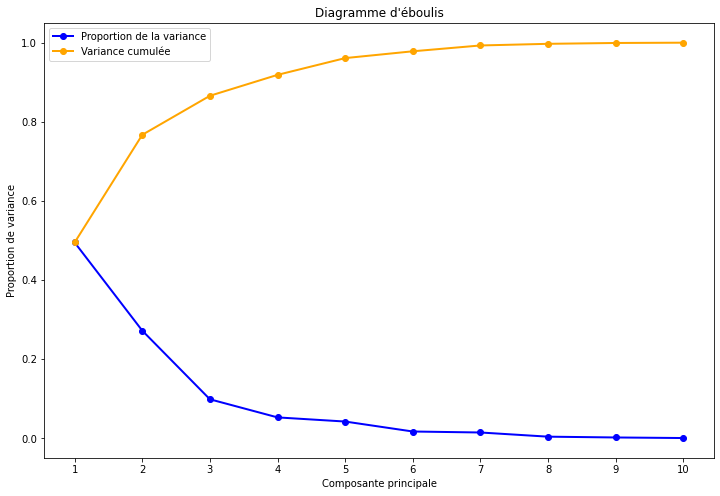

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

x_labels = [i + 1 for i in range(len(var_prop))]

ax.plot(x_labels[0:15], var_prop[0:15], marker='o', markersize=6, color='blue', linewidth=2, label="Proportion de la variance")
ax.plot(x_labels[0:15], cum_prop[0:15], marker='o', color='orange', linewidth=2, label="Variance cumulée")
ax.legend()
ax.set_xticks(x_labels[0:15])
ax.set_title("Diagramme d'éboulis")
ax.set_xlabel("Composante principale")
ax.set_ylabel("Proportion de variance")
plt.show()

Le diagramme d'éboulis ainsi que le tableau des composantes principales nous informent que 78% de la variance est expliquée par seulement
les trois premières composantes principales. On projette donc nos données sur ces trois composantes. On évalue du même coup la qualité de la représentation à l'aide de deux métriques.
- $cos(\hat{X}, X) = \frac{||\hat{X}||^2}{||X||^2}$
- $d^2(\hat{X}, X) = ||\hat{X} - X||^2$

In [22]:
M = 3
Pi = eig_vecs[:, 0:M]
Z = X @ Pi
X_hat = Z @ Pi.T
assert X_hat.shape == X.shape, "mauvais format de matrice"

d_cos = np.linalg.norm(X_hat)**2 / np.linalg.norm(X)**2
d_euc = np.linalg.norm(X_hat - X)
print("d_cos = {:.4f}\nd_euc = {:.4f}".format(d_cos, d_euc))

d_cos = 0.8658
d_euc = 13.3094


In [23]:
eig_vals[eig_vals <= 0] = 0
L = eig_vecs * np.sqrt(eig_vals)
loading_df = pd.DataFrame(
    L[:, 0:M],
    index=selected_features,
    columns=["CP-{}".format(i + 1) for i in range(len(eig_vecs[0:M]))]
)
loading_df.to_csv("loading_df.csv")
loading_df.head(74)

,CP-1,CP-2,CP-3
vsa_pol,-0.801664,0.465976,0.033044
density,-0.775801,-0.351369,0.123614
logS,0.087515,0.977676,-0.016893
balabanJ,-0.928998,0.229443,-0.017734
PC+,-0.942322,0.249551,-0.111315
h_logP,-0.276100,-0.938472,0.040978
chi1,-0.869888,-0.338573,-0.143349
bpol,-0.817233,0.374451,-0.149359
vsurf_R,0.205122,-0.152207,-0.953487
npr2,-0.635556,-0.389130,0.058790


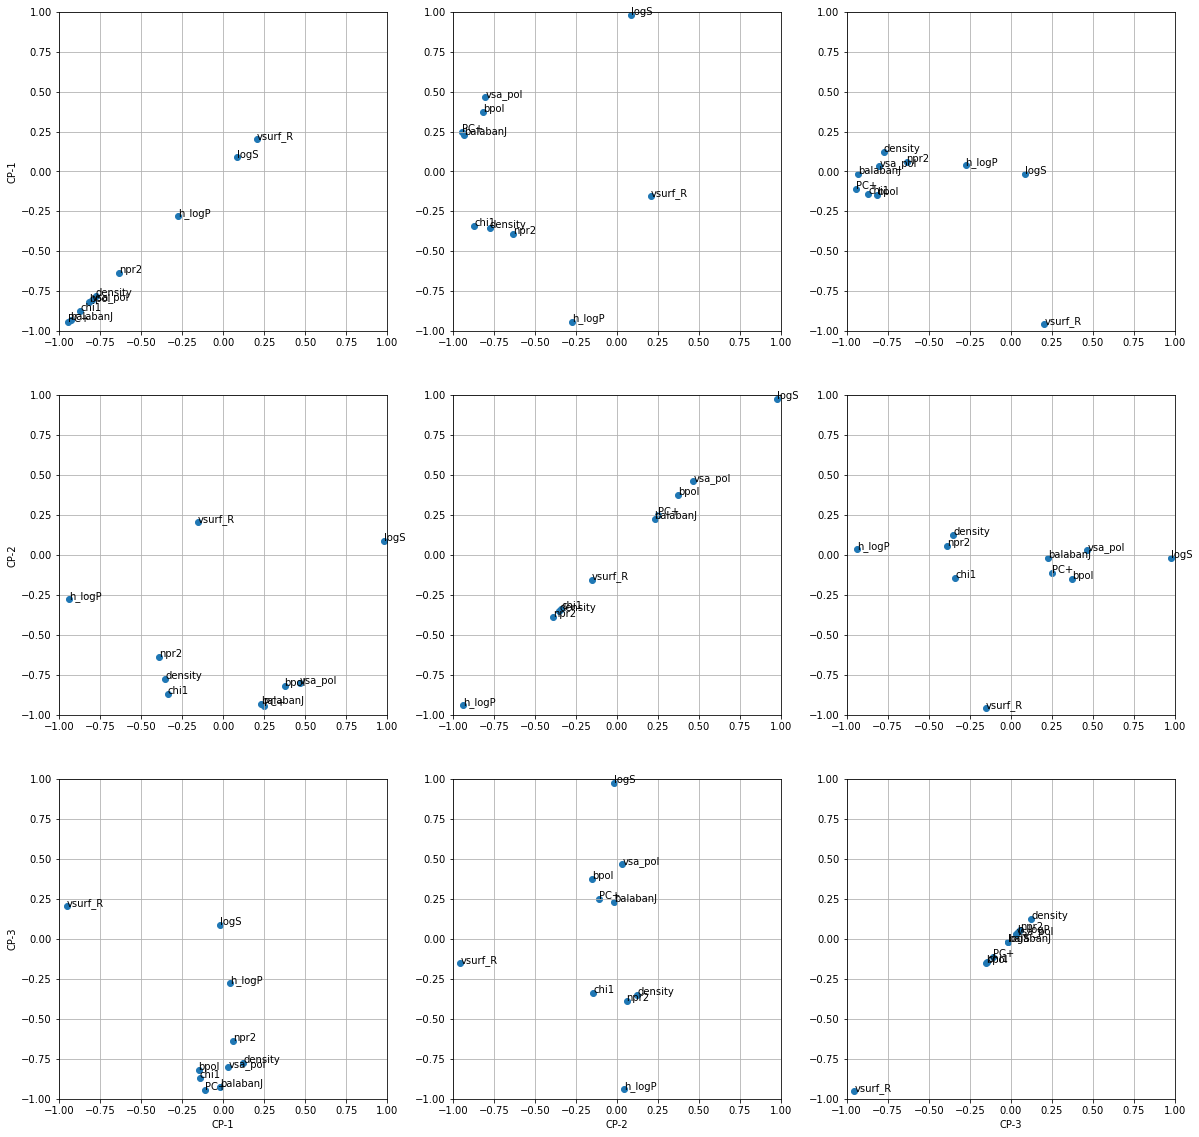

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i in range(M):
    axs[i, 0].set_ylabel("CP-{}".format(i+1))
    axs[M-1, i].set_xlabel("CP-{}".format(i+1))
    for j in range(M):
        axs[i, j].scatter(loading_df.iloc[:, i], loading_df.iloc[:, j])
        axs[i, j].set_yticks(np.arange(-1, 1.25, step=0.25))
        axs[i, j].set_xticks(np.arange(-1, 1.25, step=0.25))
        axs[i, j].set_xlim(-1, 1)
        axs[i, j].set_ylim(-1, 1)
        axs[i, j].grid()

        for k, txt in enumerate(selected_features):
            axs[i, j].annotate(txt, (loading_df.iloc[k, i], loading_df.iloc[k, j]))
        
plt.show()

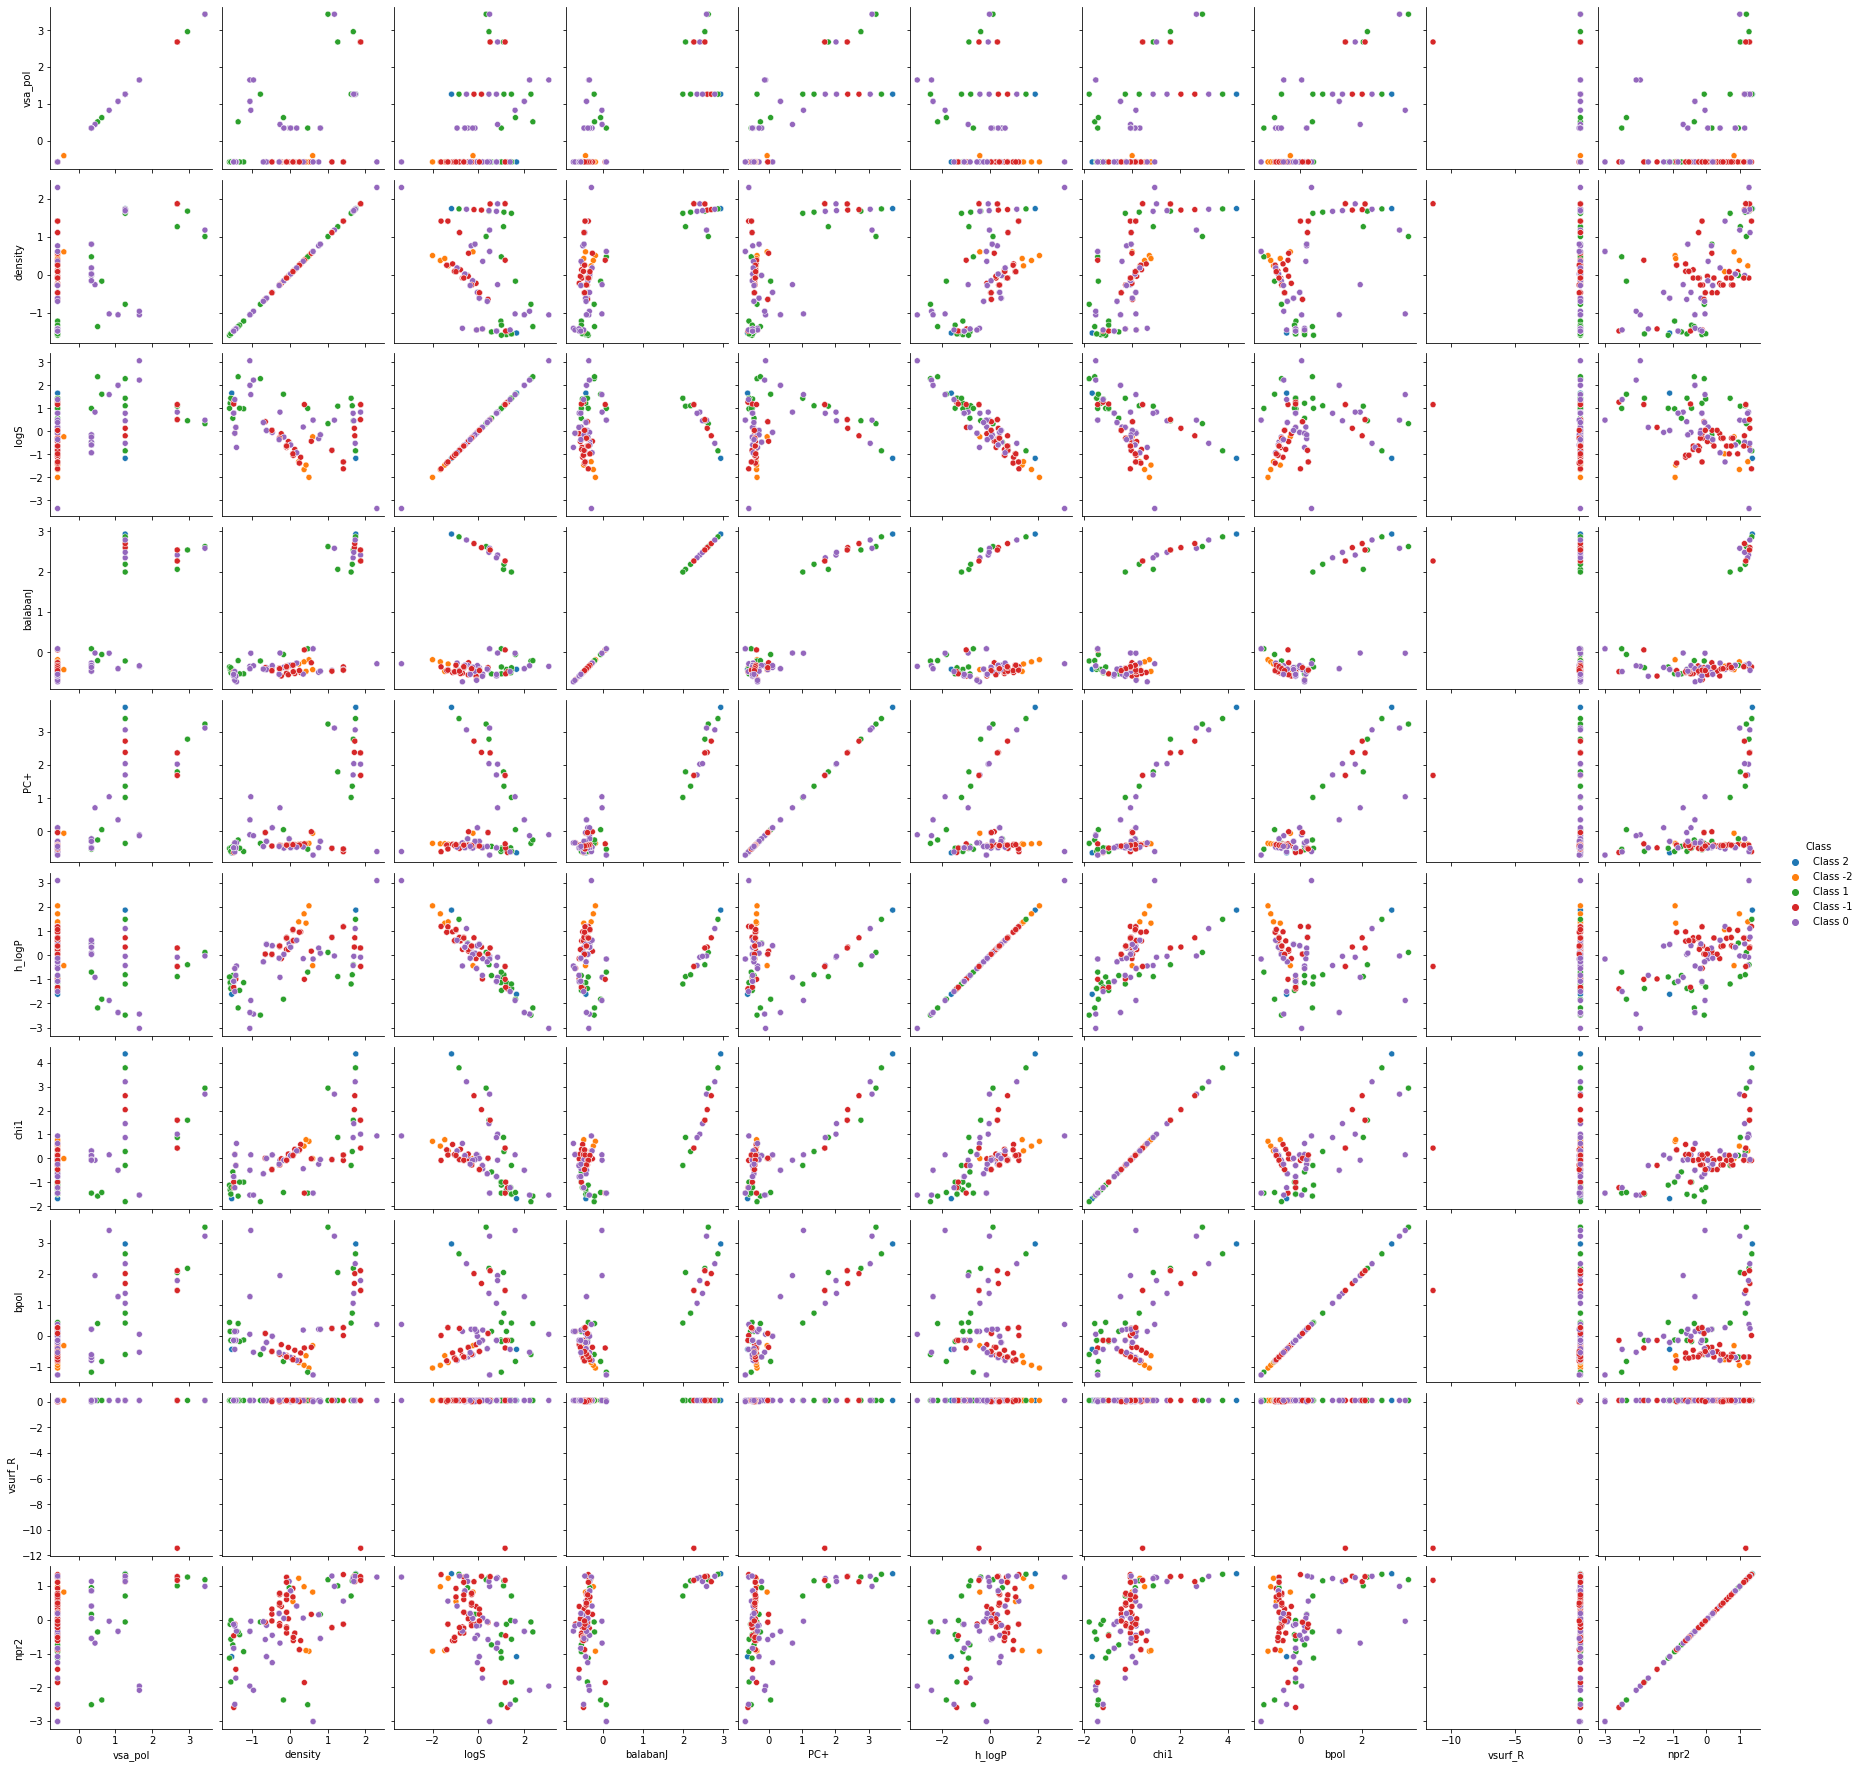

In [25]:
#c = ["VAdjEq", "a_count", "PC-", "SMR", "SlogP", "mr", "h_logS", "apol", "a_hyd", "a_heavy"]
df_subset = df_scaled.loc[:, selected_features + ["Class"]]
sns.pairplot(df_subset.reset_index(), hue="Class", diag_kind=None)

In [26]:
df_acp = pd.DataFrame(
    np.concatenate((Z, np.expand_dims(y, 1)), axis=1),
    columns=["CP-{}".format(i+1) for i in range(M)] + ["Class"],
    index=df.index
)
df_acp.head(5)

,CP-1,CP-2,CP-3,Class
SMILES,,,,
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(=O)[O-],-7.322224,-1.356838,-1.197748,4.0
c12c(cccc1)cccc2,2.593707,2.408992,-0.070256,4.0
Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)-c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,0.303166,-2.876202,0.116376,1.0
ClC1(Cl)C2(Cl)C(Cl)=C(Cl)C1(Cl)C1C2C(Cl)C2(Cl)OC12,0.075358,-0.479536,0.070910,1.0
Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)-c1c(Cl)c(Cl)c(Cl)c(Cl)c1,-0.069941,-2.856283,0.211486,1.0


Une compression parfaite donnerait un cosinus équivalent à $1$. Notre compression n'est pas mauvaise

Visualisons maintenant les cinq classes dans le nouveau sous-espace.

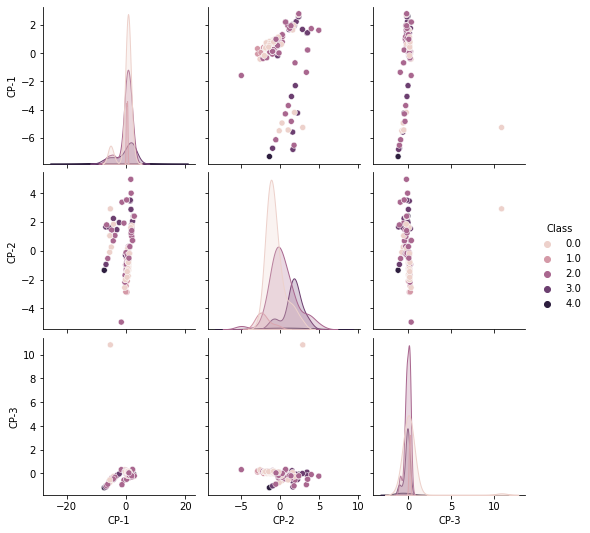

In [27]:
sns.pairplot(df_acp.reset_index(), hue="Class")

Constate que les classes sont difficilement séparables dans ce sous-espace. Examinons maintenant la dispersion des classes dans $\mathbb{R}^3$.

In [28]:
import plotly.express as px

fig = px.scatter_3d(df_acp, x=Z[:, 0], y=Z[:, 1], z=Z[:, 2], color="Class")
fig.show()

Le résultat n'est pas plus informatif.

#### Analyse de la corélation
On commencer par filtrer les attributs présentant une forte corélation. Pour simplifier l'analyse, nous considérons seulement les valeurs absolues dans la matrice de corélation, car nous sommes intéressants par les forces de corélation et non leur direction.

<AxesSubplot:>

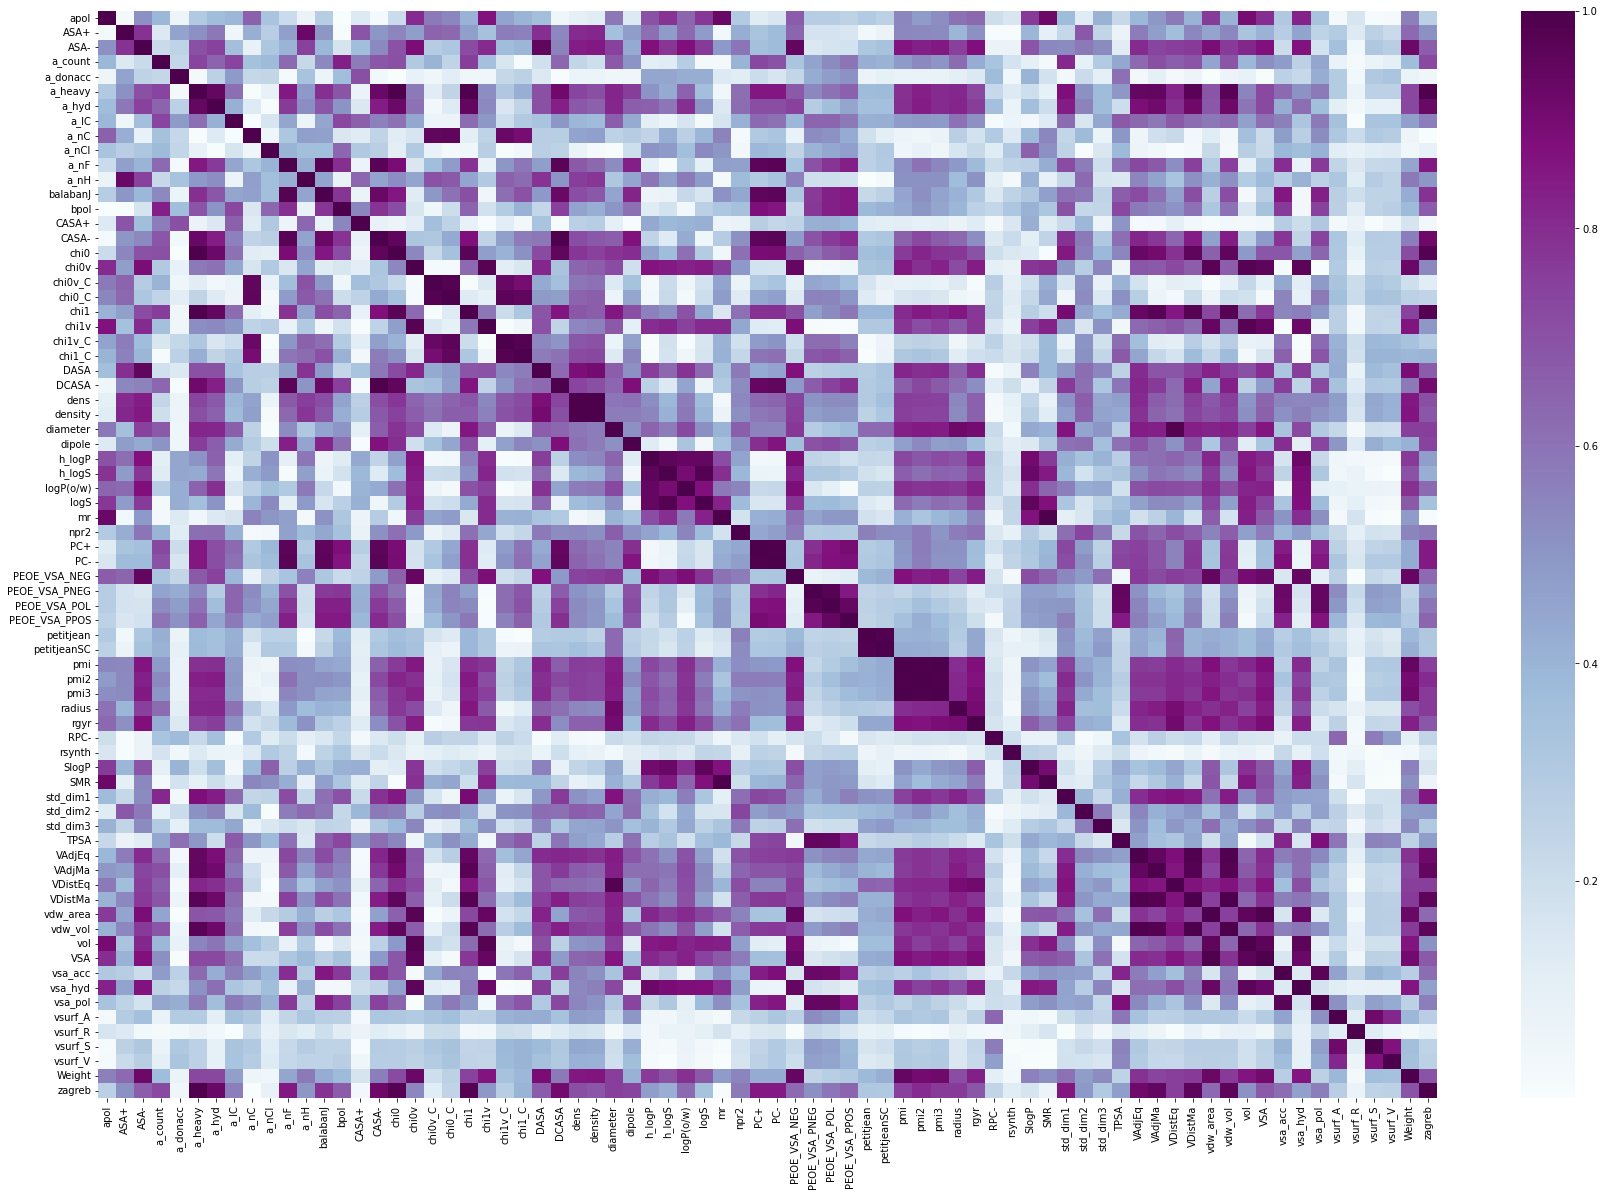

In [31]:
# Code inspiré de https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Pour simplifier l'anal, on calcule la matrice de covariance absolue.
# Ainsi, les cases bleues indiquent une absence de corrélation et les cases rouges l'inverse.
corr_mat = df_scaled[num_cols].corr().abs()
# On masque le haut de la matrice diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
f, ax = plt.subplots(figsize=(30, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat, annot=False, cmap="BuPu")

In [32]:
# Code inspiré de https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/
# Nous avons testé plusieurs ratio différents et celui-ci permettait de filtrer plusieurs attributs.
max_rho = 0.75
# Sélectionner triangle supérieur de la matrice de corrélation
upper = corr_mat.where(np.triu(np.ones_like(corr_mat), k=1).astype(bool))
# Sélectionner les attributs dont la corrélation dépasse le seuil `max_rho`
to_drop = [column for column in upper.columns if any(upper[column] >= max_rho)]
print("Total d'attributs dépassant le seuil {:.2f}: {}".format(max_rho, len(to_drop)))
print(to_drop)

Total d'attributs dépassant le seuil 0.75: 57
['ASA-', 'a_hyd', 'a_nF', 'a_nH', 'balabanJ', 'bpol', 'CASA-', 'chi0', 'chi0v', 'chi0v_C', 'chi0_C', 'chi1', 'chi1v', 'chi1v_C', 'chi1_C', 'DASA', 'DCASA', 'dens', 'density', 'diameter', 'dipole', 'h_logP', 'h_logS', 'logP(o/w)', 'logS', 'mr', 'PC+', 'PC-', 'PEOE_VSA_NEG', 'PEOE_VSA_PNEG', 'PEOE_VSA_POL', 'PEOE_VSA_PPOS', 'petitjeanSC', 'pmi', 'pmi2', 'pmi3', 'radius', 'rgyr', 'SlogP', 'SMR', 'std_dim1', 'TPSA', 'VAdjEq', 'VAdjMa', 'VDistEq', 'VDistMa', 'vdw_area', 'vdw_vol', 'vol', 'VSA', 'vsa_acc', 'vsa_hyd', 'vsa_pol', 'vsurf_S', 'vsurf_V', 'Weight', 'zagreb']


Par curiosité, on vérifie si les attributs supprimés se trouvent dans les 10 attributs sélectionnés par Catboost et SKLearn.